# 🤗 Welcome to AdalFlow!
## The PyTorch library to auto-optimize any LLM task pipelines

Thanks for trying us out, we're here to provide you with the best LLM application development experience you can dream of 😊 any questions or concerns you may have, [come talk to us on discord,](https://discord.gg/ezzszrRZvT) we're always here to help! ⭐ <i>Star us on <a href="https://github.com/SylphAI-Inc/AdalFlow">Github</a> </i> ⭐


# Quick Links

Github repo: https://github.com/SylphAI-Inc/AdalFlow

Full Tutorials: https://adalflow.sylph.ai/index.html#.

Deep dive on each API: check out the [developer notes](https://adalflow.sylph.ai/tutorials/index.html).

Common use cases along with the auto-optimization:  check out [Use cases](https://adalflow.sylph.ai/use_cases/index.html).

## 📖 Outline

This is the code for a classification optimization tutorial 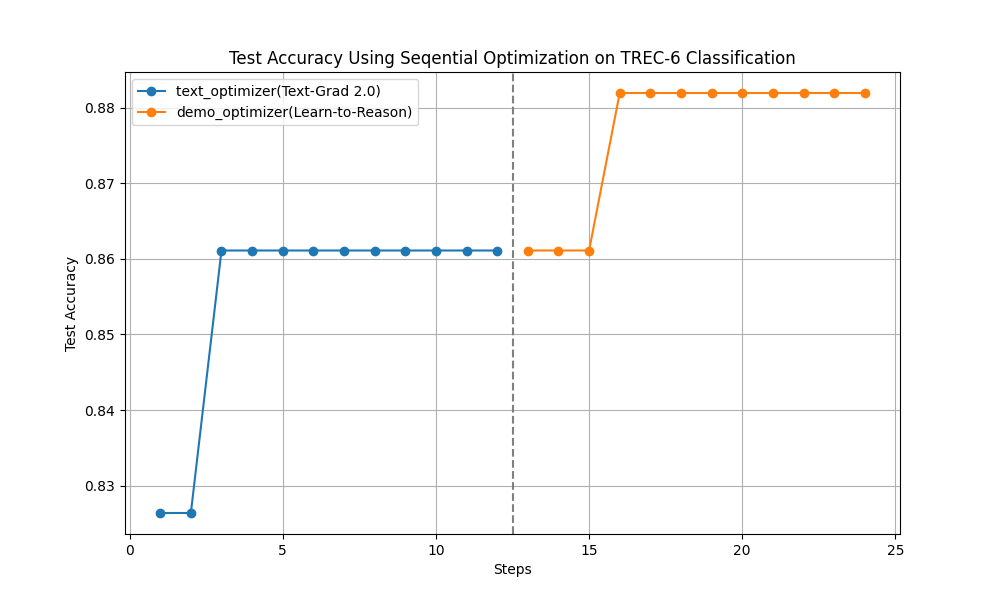



# Installation

1. Use `pip` to install the `adalflow` Python package. We will need `openai`, `groq` from the extra packages.

  ```bash
  pip install adalflow[openai,groq]
  ```
2. Setup  `openai` and `groq` API key in the environment variables

You can choose to use different client. You can import the model client you prefer. We support `Anthropic`, `Cohere`, `Google`, `GROQ`, `OpenAI`, `Transformer` and more in development. We will use OpenAI here as an example.Please refer to our [full installation guide](https://adalflow.sylph.ai/get_started/installation.html)

In [ ]:
from IPython.display import clear_output

!pip install -U adalflow[openai] # also install the package for the model client you'll use
!pip install datasets
clear_output()

## Set Environment Variables

Run the following code and pass your api key.

Note: for normal `.py` projects, follow our [official installation guide](https://lightrag.sylph.ai/get_started/installation.html).

*Go to [OpenAI](https://platform.openai.com/docs/introduction) to get API keys if you don't already have.*

In [1]:
import os

from getpass import getpass

# Prompt user to enter their API keys securely
openai_api_key = getpass("Please enter your OpenAI API key: ")


# Set environment variables
os.environ["OPENAI_API_KEY"] = openai_api_key

print("API keys have been set.")

API keys have been set.


Prepare data structures and prompt template

In [2]:
from dataclasses import dataclass, field
from typing import List, Dict, Union, Optional, Tuple, Any, Callable
from datasets import load_dataset
from adalflow.components.model_client import OpenAIClient
import adalflow as adal
from adalflow.core.component import Component
from adalflow.datasets.types import TrecData
from adalflow.datasets.trec import TrecDataset

from adalflow.eval.answer_match_acc import AnswerMatchAcc


_COARSE_LABELS = ["ABBR", "DESC", "ENTY", "HUM", "LOC", "NUM"]

_COARSE_LABELS_DESC = [
    "Abbreviation: Questions about abbreviations and their meanings",
    "Description: Questions seeking descriptions of people, things, or concepts",
    "Entity: Questions about entities (e.g., animals, colors, inventions)",
    "Human: Questions about people or organizations",
    "Location: Questions about places, cities, countries",
    "Numeric: Questions seeking numeric answers (e.g., dates, amounts, distances)",
]


template = r"""<START_OF_SYSTEM_MESSAGE>
 {{system_prompt}}
 {% if output_format_str is not none %}
 {{output_format_str}}
 {% endif %}
 {% if few_shot_demos is not none %}
 Here are some examples:
 {{few_shot_demos}}
 {% endif %}
 <END_OF_SYSTEM_MESSAGE>
 <START_OF_USER_MESSAGE>
 {{input_str}}
 <END_OF_USER_MESSAGE>
 """

task_desc_template = r"""You are a classifier. Given a question, you need to classify it into one of the following classes:
 Format: class_index. class_name, class_description
 {% if classes %}
 {% for class in classes %}
 {{loop.index-1}}. {{class.label}}, {{class.desc}}
 {% endfor %}
 {% endif %}
 - Do not try to answer the question:
 """


@dataclass
class TRECExtendedData(TrecData):
    rationale: str = field(
        metadata={
            "desc": "Your step-by-step reasoning to classify the question to class_name"
        },
        default=None,
    )
    __input_fields__ = ["question"]
    __output_fields__ = [
        "rationale",
        "class_name",
    ]  # it is important to have the rationale before the class_name


def load_datasets():
    """Load the dataset"""
    train_data = TrecDataset(split="train")
    val_data = TrecDataset(split="val")
    test_data = TrecDataset(split="test")
    return train_data, val_data, test_data  # 0.694, 0.847

In [3]:
# prepare models

from adalflow.components.model_client.openai_client import OpenAIClient

# used as the target model
gpt_3_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "gpt-3.5-turbo",
        "max_tokens": 2000,
        "temperature": 0.0,
        "top_p": 0.99,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "stop": None,
    },
}

# used as optimizer and backward engine
gpt_4o_mini_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "gpt-4o-mini",
        "temperature": 1,
        "top_p": 0.99,
        "max_tokens": 1000,
        # "frequency_penalty": 1,  # high for nto repeating prompt
    },
}

Create the task pipeline

In [4]:
class TRECClassifierStructuredOutput(adal.Component):

    def __init__(self, model_client: adal.ModelClient, model_kwargs: Dict):
        super().__init__()

        label_desc = [
            {"label": label, "desc": desc}
            for label, desc in zip(_COARSE_LABELS, _COARSE_LABELS_DESC)
        ]

        task_desc_str = adal.Prompt(
            template=task_desc_template, prompt_kwargs={"classes": label_desc}
        )()

        self.data_class = TRECExtendedData
        self.data_class.set_task_desc(task_desc_str)

        self.parser = adal.DataClassParser(
            data_class=self.data_class, return_data_class=True, format_type="yaml"
        )

        prompt_kwargs = {
            "system_prompt": adal.Parameter(
                data=self.parser.get_task_desc_str(),
                role_desc="Task description",
                requires_opt=True,
                param_type=adal.ParameterType.PROMPT,
            ),
            "output_format_str": adal.Parameter(
                data=self.parser.get_output_format_str(),
                role_desc="Output format requirements",
                requires_opt=False,
                param_type=adal.ParameterType.PROMPT,
            ),
            "few_shot_demos": adal.Parameter(
                data=None,
                requires_opt=True,
                role_desc="Few shot examples to help the model",
                param_type=adal.ParameterType.DEMOS,
            ),
        }

        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs=prompt_kwargs,
            template=template,
            output_processors=self.parser,
            use_cache=True,
        )

    def _prepare_input(self, question: str):
        input_data = self.data_class(question=question)
        input_str = self.parser.get_input_str(input_data)
        prompt_kwargs = {
            "input_str": adal.Parameter(
                data=input_str, requires_opt=False, role_desc="input to the LLM"
            )
        }
        return prompt_kwargs

    def bicall(
        self, question: str, id: Optional[str] = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        prompt_kwargs = self._prepare_input(question)
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

Inference the task pipeline and draw the computation graph

In [5]:
# load dataset to get one example

train_dataset, val_dataset, test_dataset = load_datasets()
example = train_dataset[0]
print(example)

README.md: 0.00B [00:00, ?B/s]

trec.py: 0.00B [00:00, ?B/s]

RuntimeError: Dataset scripts are no longer supported, but found trec.py

In [7]:
task = TRECClassifierStructuredOutput(
    model_client=gpt_3_model["model_client"],
    model_kwargs=gpt_3_model["model_kwargs"],
)
task.train()

output = task(question=example.question, id=example.id)
print(output)

Prompt kwargs: {'classes': [{'label': 'ABBR', 'desc': 'Abbreviation: Questions about abbreviations and their meanings'}, {'label': 'DESC', 'desc': 'Description: Questions seeking descriptions of people, things, or concepts'}, {'label': 'ENTY', 'desc': 'Entity: Questions about entities (e.g., animals, colors, inventions)'}, {'label': 'HUM', 'desc': 'Human: Questions about people or organizations'}, {'label': 'LOC', 'desc': 'Location: Questions about places, cities, countries'}, {'label': 'NUM', 'desc': 'Numeric: Questions seeking numeric answers (e.g., dates, amounts, distances)'}]}
Prompt kwargs after conversion: {'classes': [{'label': 'ABBR', 'desc': 'Abbreviation: Questions about abbreviations and their meanings'}, {'label': 'DESC', 'desc': 'Description: Questions seeking descriptions of people, things, or concepts'}, {'label': 'ENTY', 'desc': 'Entity: Questions about entities (e.g., animals, colors, inventions)'}, {'label': 'HUM', 'desc': 'Human: Questions about people or organizati

NameError: name 'example' is not defined

In [ ]:
class TrecClassifierAdal(adal.AdalComponent):
    def __init__(
        self,
        model_client: adal.ModelClient,
        model_kwargs: Dict,
        teacher_model_config: Dict,
        backward_engine_model_config: Dict,
        text_optimizer_model_config: Dict,
    ):
        task = TRECClassifierStructuredOutput(model_client, model_kwargs)
        eval_fn = AnswerMatchAcc(type="exact_match").compute_single_item
        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=eval_fn,
            eval_fn_desc="exact_match: 1 if str(y) == str(y_gt) else 0. When the LLM prediction failed with format parsing which results with errors, we set y_pred = -1",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
            teacher_model_config=teacher_model_config,
        )

    def prepare_task(self, sample: TRECExtendedData):
        return self.task.call, {"question": sample.question, "id": sample.id}

    def prepare_eval(
        self, sample: TRECExtendedData, y_pred: adal.GeneratorOutput
    ) -> float:
        y_label = -1
        if y_pred and y_pred.data is not None and y_pred.data.class_name is not None:
            y_label = y_pred.data.class_name
        return self.eval_fn, {"y": y_label, "y_gt": sample.class_name}

    def prepare_loss(
        self, sample: TRECExtendedData, y_pred: adal.Parameter, *args, **kwargs
    ) -> Tuple[Callable[..., Any], Dict]:
        full_response = y_pred.data
        y_label = -1  # default value for failed prediction
        if (
            full_response
            and full_response.data is not None
            and full_response.data.class_name is not None
        ):
            y_label = full_response.data.class_name

        y_pred.eval_input = y_label
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.class_name,
            eval_input=sample.class_name,
            requires_opt=False,
        )
        return self.loss_fn, {
            "kwargs": {"y": y_pred, "y_gt": y_gt},
            "id": sample.id,
            "gt": y_gt.eval_input,
        }

In [ ]:
def train(
    model_client: adal.ModelClient,
    model_kwargs: Dict,
    train_batch_size=4,
    raw_shots: int = 0,
    bootstrap_shots: int = 1,
    max_steps=12,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
):
    print("Starting training process...")

    # Define the model configuration for all components
    gpt_4o_model = {
        "model_client": OpenAIClient(),
        "model_kwargs": {
            "model": "gpt-4o-mini",
            "temperature": 1,
            "top_p": 0.99,
            "max_tokens": 1000,
            # "frequency_penalty": 1,  # high for nto repeating prompt
        },
    }

    print(f"Component model configuration: {gpt_4o_model}")

    try:
        print("Initializing ADAL component...")
        adal_component = TrecClassifierAdal(
            model_client=model_client,
            model_kwargs=model_kwargs,
            text_optimizer_model_config=gpt_4o_model,
            backward_engine_model_config=gpt_4o_model,
            teacher_model_config=gpt_4o_model,
        )
        print("ADAL component initialized successfully")

        print("Initializing trainer...")
        trainer = adal.Trainer(
            train_batch_size=train_batch_size,
            adaltask=adal_component,
            strategy=strategy,
            max_steps=max_steps,
            num_workers=num_workers,
            raw_shots=raw_shots,
            bootstrap_shots=bootstrap_shots,
            debug=debug,
            weighted_sampling=True,
            optimization_order=optimization_order,
            exclude_input_fields_from_bootstrap_demos=True,
        )
        print("Trainer initialized successfully")

        print("Loading datasets...")
        train_dataset, val_dataset, test_dataset = load_datasets()
        print(
            f"Datasets loaded - Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}"
        )

        print("Starting model training...")
        trainer.fit(
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            test_dataset=test_dataset,
            debug=debug,
        )
        print("Training completed successfully")

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

In [ ]:
train(**gpt_3_model)

Starting training process...
Component model configuration: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4o-mini', 'temperature': 1, 'top_p': 0.99, 'max_tokens': 1000}}
Initializing ADAL component...
ADAL component initialized successfully
Initializing trainer...
Trainer initialized successfully
Loading datasets...
Datasets loaded - Train size: 120, Val size: 36, Test size: 144
Starting model training...
raw_shots: 0, bootstrap_shots: 1
Configuring teacher generator.
Configuring teacher generator for Generator(
  model_kwargs={'model': 'gpt-4o-mini', 'temperature': 1, 'top_p': 0.99, 'max_tokens': 1000}, trainable_prompt_kwargs=[]
  (prompt): Prompt(
    template: <START_OF_SYSTEM_MESSAGE>
     {{system_prompt}}
     {% if output_format_str is not none %}
     {{output_format_str}}
     {% endif %}
     {% if few_shot_demos is not none %}
     Here are some examples:
     {{few_shot_demos}}
     {% endif %}
     <END_OF_SYSTEM_MESSAGE>
     <START_OF_USER_MESSAGE>
   


Loading Data: 100%|██████████| 144/144 [00:00<00:00, 9161.62it/s]
Predicting: step(0): 0.8264 across 144 samples, Max potential: 0.8264: 100%|██████████| 144/144 [00:19<00:00,  7.39it/s]


completed_samples: 144, len: 144
Initial validation score: 0.8263888888888888
Initial test score: None
Checkpoint path: /root/.adalflow/ckpt/TrecClassifierAdal
save to /root/.adalflow/ckpt/TrecClassifierAdal/constrained_max_steps_12_a6e76_run_1.json



Training Step: 1:   0%|          | 0/30 [00:00<?, ?it/s]

Training: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5187.76it/s]


Moving batch acc: 0.75
Moving batch correct size: 3
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6666666666666666
Subset batch acc: 0.6666666666666666
Subset loss backward...
setting pred name Generator_outputy_pred_3 score to 1.0
setting pred name Generator_outputy_pred_1 score to 1.0
setting pred name Generator_outputy_pred_2 score to 0.0
Subset loss backward time: 10.694303750991821
Optimizer propose...




Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

New prompts:  [PromptData(id='53b75924-9350-4ffb-9710-64652feabf23', name='llm.system_prompt', data='You are a classifier. Given a question, classify it into one of the classes:\nFormat: class_index. class_name, class_description\n0. ABBR, Abbreviation: Questions about abbreviations and their meanings\n1. DESC, Description: Questions seeking descriptions of people, things, or concepts\n2. ENTY, Entity: Questions about entities (e.g., animals, colors, inventions)\n3. HUM, Human: Questions about people or organizations\n4. LOC, Location: Questions about places, cities, countries\n5. NUM, Numeric: Questions seeking numeric answers (e.g., dates, amounts, distances)\n- Do not attempt to answer the question directly. Ensure your classification is precise and reflects the specific focus of the inquiry:', requires_opt=True), PromptData(id='2218906f-9600-4ff8-8532-a8038ef6cb63', name='llm.output_format_str', data='Your output should be formatted as a standard YAML instance with the following sc




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 651.26it/s]
Predicting: step(0): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Proposing:  20%|██        | 1/5 [00:03<00:13,  3.27s/it]

completed_samples: 3, len: 3
Fail subset check, try next proposal: 0.6666666666666666 <= 0.6666666666666666
New prompts:  [PromptData(id='53b75924-9350-4ffb-9710-64652feabf23', name='llm.system_prompt', data='You are a classifier. Given a question, classify it into one of the following classes by following these guidelines: \nFormat: class_index. class_name, class_description \n0. ABBR, Abbreviation: Questions about abbreviations and their meanings \n1. DESC, Description: Questions seeking descriptions of people, things, or concepts \n2. ENTY, Entity: Questions about entities (e.g., animals, colors, inventions) \n3. HUM, Human: Questions about people or organizations \n4. LOC, Location: Questions about places, cities, countries \n5. NUM, Numeric: Questions seeking numeric answers (e.g., dates, amounts, distances) \n- Avoid attempting to directly answer the question; instead, focus on accurate classification based on specific criteria: \n- Ensure the category accurately represents the e




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 302.95it/s]
Predicting: step(0): 0.6667 across 3 samples, Max potential: 0.6667: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Proposing:  40%|████      | 2/5 [00:06<00:09,  3.24s/it]

completed_samples: 3, len: 3
Fail subset check, try next proposal: 0.6666666666666666 <= 0.6666666666666666


Epoch:   0%|          | 0/1 [00:18<?, ?it/s]


KeyboardInterrupt: 

# Issues and feedback

If you encounter any issues, please report them here: [GitHub Issues](https://github.com/SylphAI-Inc/LightRAG/issues).

For feedback, you can use either the [GitHub discussions](https://github.com/SylphAI-Inc/LightRAG/discussions) or [Discord](https://discord.gg/ezzszrRZvT).